# Week 2 - Corpus Linguistics

This week, we take text corpora that we have developed, spidered, scraped, and encoded, and we find and count words and simple phrases and properties of those counts (e.g., word frequency distributions). Initially, we model how to search corpora for keywords or phrases. Next, we examine the distributions of terms and phrases across a corpus, and the corelation between different words and phrase counts. In order to do this effectively, we coarsely disambiguate words based of part-of-speech (POS) tagging, and normalize them through stemming and lemmatization. Next we distinguish *important* words and phrase within the corpus, and image them with Wordls! Then we calculate word frequenceis, conditional frequences (the frequency of word *shock* conditional on the presence of word *awe*), and statistically significant collocations of lengths 2 through $n$. Finally, we calculate and visualize Differences (Divergences and Distances) between the word frequency distributions from two corpora. 

For this notebook we will be using the following packages

In [1]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
import lucem_illud #pip install git+git://github.com/Computational-Content-Analysis-2018/lucem_illud.git

#All these packages need to be installed from pip
import requests #for http requests
import nltk #the Natural Language Toolkit
import pandas #gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import wordcloud #Makes word clouds
import numpy as np #For divergences/distances
import scipy #For divergences/distances
import seaborn as sns #makes our plots look nicer
import sklearn.manifold #For a manifold plot
from nltk.corpus import stopwords #For stopwords
import json #For API responses
import urllib.parse #For joining urls

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook
%matplotlib inline

# Retrieving exemplary corpora

To get started we will need some examples. Let's start by downloading one of the corpuses from `nltk`, a Natural Language Toolkit developed by computational linguists at the University of Pennsylvania. Let's take a look at how that works.

First we can get a list of works available from the Gutenburg corpus, with the [corpus module](http://www.nltk.org/api/nltk.corpus.html). To do this we will need to tell nltk where the data are, and download them if need be.

In [2]:
#You should have them already downloaded in the data directory
try:
    #adding path for both local and server, only one of these will actually be used at a time
    nltk.data.path.append('/project2/macs60000/shared_data/nltk')
    nltk.data.path.append('../data')
    #Check that everything is in place
    nltk.corpus.gutenberg.fileids()
except LookupError:
    print("You have to download all the documents")
    print("Downloading to ../data this should only take a couple minutes")
    nltk.download('all', download_dir = '../data')
    nltk.data.path.append('../data')
#If you haven't downloaded the copura then you will have to run `nltk.download()`
print(nltk.corpus.gutenberg.fileids())
print(len(nltk.corpus.gutenberg.fileids()))

['austen-emma.txt', 'austen-persuasion.txt', 'austen-sense.txt', 'bible-kjv.txt', 'blake-poems.txt', 'bryant-stories.txt', 'burgess-busterbrown.txt', 'carroll-alice.txt', 'chesterton-ball.txt', 'chesterton-brown.txt', 'chesterton-thursday.txt', 'edgeworth-parents.txt', 'melville-moby_dick.txt', 'milton-paradise.txt', 'shakespeare-caesar.txt', 'shakespeare-hamlet.txt', 'shakespeare-macbeth.txt', 'whitman-leaves.txt']
18


We can also look at the individual works

In [4]:
nltk.corpus.gutenberg.raw('shakespeare-macbeth.txt')[2000:4000]

"es,\nBut the Norweyan Lord, surueying vantage,\nWith furbusht Armes, and new supplyes of men,\nBegan a fresh assault\n\n   King. Dismay'd not this our Captaines, Macbeth and\nBanquoh?\n  Cap. Yes, as Sparrowes, Eagles;\nOr the Hare, the Lyon:\nIf I say sooth, I must report they were\nAs Cannons ouer-charg'd with double Cracks,\nSo they doubly redoubled stroakes vpon the Foe:\nExcept they meant to bathe in reeking Wounds,\nOr memorize another Golgotha,\nI cannot tell: but I am faint,\nMy Gashes cry for helpe\n\n   King. So well thy words become thee, as thy wounds,\nThey smack of Honor both: Goe get him Surgeons.\nEnter Rosse and Angus.\n\nWho comes here?\n  Mal. The worthy Thane of Rosse\n\n   Lenox. What a haste lookes through his eyes?\nSo should he looke, that seemes to speake things strange\n\n   Rosse. God saue the King\n\n   King. Whence cam'st thou, worthy Thane?\n  Rosse. From Fiffe, great King,\nWhere the Norweyan Banners flowt the Skie,\nAnd fanne our people cold.\nNorway hi

All the listed works have been nicely marked up and classified for us so we can do much better than just looking at raw text.

In [5]:
print(nltk.corpus.gutenberg.words('shakespeare-macbeth.txt'))
print(nltk.corpus.gutenberg.sents('shakespeare-macbeth.txt'))

['[', 'The', 'Tragedie', 'of', 'Macbeth', 'by', ...]
[['[', 'The', 'Tragedie', 'of', 'Macbeth', 'by', 'William', 'Shakespeare', '1603', ']'], ['Actus', 'Primus', '.'], ...]


# Counting words

If we want to do some analysis we can start by simply counting the number of times each word occurs within the corpus.

In [6]:
def wordCounter(wordLst):
    wordCounts = {}
    for word in wordLst:
        #We usually need to normalize the case
        wLower = word.lower()
        if wLower in wordCounts:
            wordCounts[wLower] += 1
        else:
            wordCounts[wLower] = 1
    #convert to DataFrame
    countsForFrame = {'word' : [], 'count' : []}
    for w, c in wordCounts.items():
        countsForFrame['word'].append(w)
        countsForFrame['count'].append(c)
    return pandas.DataFrame(countsForFrame)

countedWords = wordCounter(nltk.corpus.gutenberg.words('shakespeare-macbeth.txt'))
countedWords[:10]

,count,word
0,4,[
1,650,the
2,2,tragedie
3,338,of
4,62,macbeth
5,49,by
6,1,william
7,1,shakespeare
8,1,1603
9,4,]


Notice how `wordCounter()` is not a very complicated function. That is because the hard parts have already been done by `nltk`. If we were using unprocessed text we would have to tokenize and determine what to do with the non-word characters.

nltk also offers a built-in way for getting a frequency distribution from a list of words:

In [7]:
words = [word.lower() for word in nltk.corpus.gutenberg.words('shakespeare-macbeth.txt')]
freq = nltk.FreqDist(words)
print (freq['macbeth'])

62


Lets sort and plot our counts to investigate the shape of our word frequency distribution.

First we need to sort the words by count.

In [8]:
#Doing this in place (changing the original DataFrame) as we don't need the unsorted DataFrame
countedWords.sort_values('count', ascending=False, inplace=True)
countedWords[:100]

,count,word
29,1962,","
12,1235,.
1,650,the
36,637,'
16,546,and
64,477,:
54,384,to
56,348,i
3,338,of
27,241,?


Punctuation and very common words (articles 'a' and 'the'; prepositions 'of' and 'to') make up the most common values, but this isn't very interesting and can actually get in the way of our analysis. We may remove these 'function words' by removing according to a stopword list, setting some frequency threshold, or using a weighting scheme (like tf.idf) to decrease their influence (all modeled later in this tutorial).

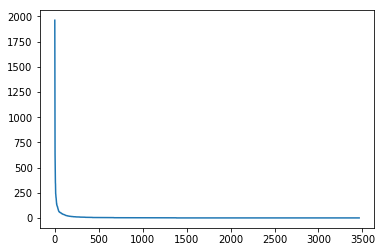

In [9]:
#Creating a figure and axis lets us do things like change the scaling or add a title
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(range(len(countedWords)), countedWords['count'])
plt.show()

This shows that likelihood of a word occurring is inversely proportional to its rank. This effect is called [Zipf's Law](https://en.wikipedia.org/wiki/Zipf%27s_law), and suggests that the most frequent word will occur approximately twice as often as the second most frequent word, three times as often as the third most frequent word, etc. Zipf's law is most easily observed by plotting the data on a log-log graph, with the axes being log (rank order) and log (frequency) resulting in a linear relationship.

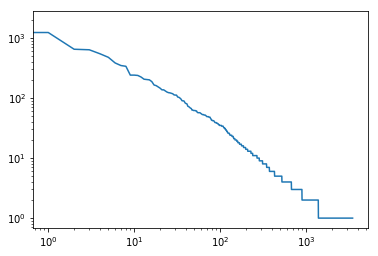

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(range(len(countedWords)), countedWords['count'])
ax.set_yscale('log')
ax.set_xscale('log')
plt.show()

(The same relationship occurs in many other rankings, such as population ranks of cities, corporation sizes, income rankings, etc.) 

The distribution was imagined by Zipf to be driven by a principle of 'least effort' where speakers did not work any harder than necessary to communicate a given idea, but the basis for this relationship is still not well understood and conforms at least as well to a process of [preferential attachment](https://en.wikipedia.org/wiki/Preferential_attachment) whereby people disproportionately attend to popular words.

There are many other properties of words we can examine. First lets look surrounding words with the concordance. To do this we need to load the text into a `ConcordanceIndex`

In [11]:
macbethIndex = nltk.text.ConcordanceIndex(nltk.corpus.gutenberg.words('shakespeare-macbeth.txt'))

Then we can retrieve all the words that cooccur with a word in a given word window. Let's first look at `'macbeth'`.

In [12]:
macbethIndex.print_concordance('macbeth')

No matches


Weird?! `'macbeth'` doesn't occur anywhere in the the text. What happened?

`ConcordanceIndex` is case sensitive, lets try looking for `'Macbeth'`

In [13]:
macbethIndex.print_concordance('Macbeth')

Displaying 25 of 61 matches:
                                  Macbeth by William Shakespeare 1603 ] Act
 the Heath 3 . There to meet with Macbeth 1 . I come , Gray - Malkin All . 
but all ' s too weake : For braue Macbeth ( well hee deserues that Name ) D
smay ' d not this our Captaines , Macbeth and Banquoh ? Cap . Yes , as Spar
, And with his former Title greet Macbeth Rosse . Ile see it done King . Wh
 King . What he hath lost , Noble Macbeth hath wonne . Exeunt . Scena Terti
ithin . 3 . A Drumme , a Drumme : Macbeth doth come All . The weyward Siste
, the Charme ' s wound vp . Enter Macbeth and Banquo . Macb . So foule and 
an : what are you ? 1 . All haile Macbeth , haile to thee Thane of Glamis 2
hee Thane of Glamis 2 . All haile Macbeth , haile to thee Thane of Cawdor 3
hee Thane of Cawdor 3 . All haile Macbeth , that shalt be King hereafter Ba
. Hayle 3 . Hayle 1 . Lesser than Macbeth , and greater 2 . Not so happy , 
hough thou be none : So all haile Macbeth , and Banquo 1 . 

That's better. What about something a lot less frequent?

In [14]:
print(countedWords[countedWords['word'] == 'donalbaine'])
macbethIndex.print_concordance('Donalbaine')

    count        word
80      7  donalbaine
Displaying 7 of 7 matches:
m within . Enter King Malcome , Donalbaine , Lenox , with attendants , mee
Enter King , Lenox , Malcolme , Donalbaine , and Attendants . King . Is ex
rches . Enter King , Malcolme , Donalbaine , Banquo , Lenox , Macduff , Ro
 ' th ' second Chamber ? Lady . Donalbaine Mac . This is a sorry sight Lad
er , and Treason , Banquo , and Donalbaine : Malcolme awake , Shake off th
to brag of . Enter Malcolme and Donalbaine . Donal . What is amisse ? Macb
were subborned , Malcolme , and Donalbaine the Kings two Sonnes Are stolne


# Getting and working with raw text

First, we will retrieve a collection of press releases from a *GitHub API* that archived them, based on a number of analyses by Justin Grimmer, a political scientist whose work we will read next week, and who will be joining the University of Chicago next July!

GitHub API requests are made to `'https://api.github.com/'` and responses are in JSON, similar to Tumblr's API.

We will get the information on [github.com/lintool/GrimmerSenatePressReleases](https://github.com/lintool/GrimmerSenatePressReleases) as it contains a nice set documents.

In [16]:
r = requests.get('https://api.github.com/repos/lintool/GrimmerSenatePressReleases')
senateReleasesData = json.loads(r.text)
print(senateReleasesData.keys())
print(senateReleasesData['description'])

dict_keys(['id', 'name', 'full_name', 'owner', 'private', 'html_url', 'description', 'fork', 'url', 'forks_url', 'keys_url', 'collaborators_url', 'teams_url', 'hooks_url', 'issue_events_url', 'events_url', 'assignees_url', 'branches_url', 'tags_url', 'blobs_url', 'git_tags_url', 'git_refs_url', 'trees_url', 'statuses_url', 'languages_url', 'stargazers_url', 'contributors_url', 'subscribers_url', 'subscription_url', 'commits_url', 'git_commits_url', 'comments_url', 'issue_comment_url', 'contents_url', 'compare_url', 'merges_url', 'archive_url', 'downloads_url', 'issues_url', 'pulls_url', 'milestones_url', 'notifications_url', 'labels_url', 'releases_url', 'deployments_url', 'created_at', 'updated_at', 'pushed_at', 'git_url', 'ssh_url', 'clone_url', 'svn_url', 'homepage', 'size', 'stargazers_count', 'watchers_count', 'language', 'has_issues', 'has_projects', 'has_downloads', 'has_wiki', 'has_pages', 'forks_count', 'mirror_url', 'archived', 'open_issues_count', 'license', 'forks', 'open_i

What we are interested in here is the `'contents_url'`

In [17]:
print(senateReleasesData['contents_url'])

https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/{+path}


We can use this to get any or all of the files from the repo.

In [18]:
r = requests.get('https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Whitehouse')
whitehouseLinks = json.loads(r.text)
whitehouseLinks[0]

{'_links': {'git': 'https://api.github.com/repos/lintool/GrimmerSenatePressReleases/git/blobs/f524289ee563dca58690c8d36c23dce5dbd9962a',
  'html': 'https://github.com/lintool/GrimmerSenatePressReleases/blob/master/raw/Whitehouse/10Apr2007Whitehouse123.txt',
  'self': 'https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Whitehouse/10Apr2007Whitehouse123.txt?ref=master'},
 'download_url': 'https://raw.githubusercontent.com/lintool/GrimmerSenatePressReleases/master/raw/Whitehouse/10Apr2007Whitehouse123.txt',
 'git_url': 'https://api.github.com/repos/lintool/GrimmerSenatePressReleases/git/blobs/f524289ee563dca58690c8d36c23dce5dbd9962a',
 'html_url': 'https://github.com/lintool/GrimmerSenatePressReleases/blob/master/raw/Whitehouse/10Apr2007Whitehouse123.txt',
 'name': '10Apr2007Whitehouse123.txt',
 'path': 'raw/Whitehouse/10Apr2007Whitehouse123.txt',
 'sha': 'f524289ee563dca58690c8d36c23dce5dbd9962a',
 'size': 2206,
 'type': 'file',
 'url': 'https://api.github.com/r

Now we have a list of information about Whitehouse press releases. Let's look at one of them.

In [19]:
r = requests.get(whitehouseLinks[0]['download_url'])
whitehouseRelease = r.text
print(whitehouseRelease[:1000])
len(whitehouseRelease)

SEN. WHITEHOUSE SHARES WESTERLY GIRL'S STORY IN PUSH FOR STEM CELL RESEARCH
  Sharing the story of Lila Barber, a 12 year old girl from Westerly, Sen. Sheldon Whitehouse (D-R.I.) on Tuesday, April 10, 2007, illustrated the hope stem cell research can offer in a speech on the Senate floor in favor of legislation to expand federal funding for stem cell research.  
   Whitehouse met Lila two weeks ago. She was diagnosed two years ago with osteosarcoma, a cancerous bone condition, and last year underwent cadaver bone transplant surgery. The procedure saved her leg and is helping her remain cancer-free, but the transplanted tissue will not grow with her and likely will break down over time. Stem cell research, Whitehouse explained, could vastly improve the care of patients like Lila by allowing surgeons to enhance transplants with a patient's own stem cells, which could replace the lost bone and cartilage, or grow entirely new replacement bones and joints. 
   "Stem cell research gives hope

2206

Now we have a string of correctly encoded text, similar to those we constructed from last week's assignment. For analysis of its words, next we need to tokenize it, or to split it into a sequence of tokens or word instances.

In [20]:
whTokens = nltk.word_tokenize(whitehouseRelease)
whTokens[10:30]

['STEM',
 'CELL',
 'RESEARCH',
 'Sharing',
 'the',
 'story',
 'of',
 'Lila',
 'Barber',
 ',',
 'a',
 '12',
 'year',
 'old',
 'girl',
 'from',
 'Westerly',
 ',',
 'Sen.',
 'Sheldon']

`whTokens` is a list of 'words' constructed from nltk's `word_tokenize` method built on the [Penn Treebank tokenizer](http://www.nltk.org/api/nltk.tokenize.html#module-nltk.tokenize.treebank). While it's better than `.split(' ')`, a general python string method that splits on whitespace, it is not perfect. There are many different ways to tokenize a string. `word_tokenize` is unfortunately unaware of sentences and is essentially a complicated regular expression (regex) run across the string.

If we want to find sentences we can use something like `nltk.sent_tokenize()`, which implements the [Punkt Sentence tokenizer](http://www.nltk.org/api/nltk.tokenize.html#nltk.tokenize.punkt.PunktSentenceTokenizer), a machine learning based algorithm that works well for many European languages.

We could also use the [Stanford tokenizer](http://www.nltk.org/api/nltk.tokenize.html#module-nltk.tokenize.stanford) or construct our own regex with [`RegexpTokenizer()`](http://www.nltk.org/api/nltk.tokenize.html#module-nltk.tokenize.regexp). Picking the correct tokenizer is important as the tokens form the base of our analysis.

For our purposes in this example, the Penn Treebank tokenizer is fine.

To use the list of tokens in `nltk`, and take advantage of functions like `concordance`, shown above, we can convert it into a `Text`.

In [21]:
whText = nltk.Text(whTokens)

whitehouseIndex = nltk.text.ConcordanceIndex(whText) 
whitehouseIndex.print_concordance('Whitehouse')

Displaying 5 of 5 matches:
rl from Westerly , Sen. Sheldon Whitehouse ( D-R.I. ) on Tuesday , April 1
unding for stem cell research . Whitehouse met Lila two weeks ago . She wa
ver time . Stem cell research , Whitehouse explained , could vastly improv
ch might help or even cure , '' Whitehouse said . Whitehouse also praised 
ven cure , '' Whitehouse said . Whitehouse also praised the efforts of Rho


*Note* that the `Text` class is for doing rapid, exploratory analysis. It provides an easy interface to many of the operations we want to do, but it does not allow us much control over the particular operations it glosses. When you are doing a more complete analysis, you should be using the module specifically designed for that task instead of the shortcut method `Text` provides, e.g. use  [`collocations` Module](http://www.nltk.org/api/nltk.html#module-nltk.collocations) instead of `.collocations()`.

Now that we have gotten this loaded, let's glance at few features we will delve into more deeply later.

For example, we can find words that statistically tend to occur together and typically have a composite, idiomatic meaning irreducible to the semantics of its component words. We will do this later with more control over exactly how these are identified.

In [22]:
whText.collocations()

Rhode Island; stem cells; cell research; Cell Enhancement; Enhancement
Act; President Bush; Stem Cell; stem cell; Stem cell


Or we can pick a word (or words) and find what words tend to occur around it.

In [23]:
whText.common_contexts(['stem'])

for_cell hope_cell ._cell own_cells ``_cell of_cell on_cells the_cell
embryonic_cells


We can also just count the number of times the word occurs.

In [24]:
whText.count('cell')

5


We can also plot each time a set of words occurs.

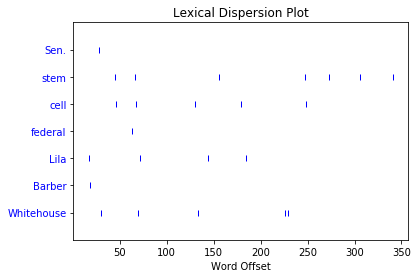

In [25]:
sns.reset_orig() #Seaborn messes with this plot, disabling it
whText.dispersion_plot(['Sen.','stem', 'cell', 'federal' ,'Lila', 'Barber', 'Whitehouse'])
sns.set() #Re-enabling seaborn

If we want to do an analysis of all the Whitehouse press releases we will first need to obtain them. By looking at the API we can see the the URL we want is [https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Whitehouse](https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Whitehouse), so we can create a function to scrape the individual files.

If you want to know more about downloading from APIs, refer back to the 1st notebook.

In [26]:
def getGithubFiles(target, maxFiles = 100):
    #We are setting a max so our examples don't take too long to run
    #For converting to a DataFrame
    releasesDict = {
        'name' : [], #The name of the file
        'text' : [], #The text of the file, watch out for binary files
        'path' : [], #The path in the git repo to the file
        'html_url' : [], #The url to see the file on Github
        'download_url' : [], #The url to download the file
    }

    #Get the directory information from Github
    r = requests.get(target)
    filesLst = json.loads(r.text)

    for fileDict in filesLst[:maxFiles]:
        #These are provided by the directory
        releasesDict['name'].append(fileDict['name'])
        releasesDict['path'].append(fileDict['path'])
        releasesDict['html_url'].append(fileDict['html_url'])
        releasesDict['download_url'].append(fileDict['download_url'])

        #We need to download the text though
        text = requests.get(fileDict['download_url']).text
        releasesDict['text'].append(text)

    return pandas.DataFrame(releasesDict)

whReleases = getGithubFiles('https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Whitehouse', maxFiles = 10)
whReleases[:5]

,download_url,html_url,name,path,text
0,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Apr2007Whitehouse123.txt,raw/Whitehouse/10Apr2007Whitehouse123.txt,SEN. WHITEHOUSE SHARES WESTERLY GIRL'S STORY I...
1,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Apr2008Whitehouse2.txt,raw/Whitehouse/10Apr2008Whitehouse2.txt,SEN. WHITEHOUSE SAYS PRESIDENT BUSH MUST BEGIN...
2,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Apr2008Whitehouse3.txt,raw/Whitehouse/10Apr2008Whitehouse3.txt,EPA MUST REVIEW LEGAL PROCESS TO ROOT OUT POLI...
3,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Aug2007Whitehouse78.txt,raw/Whitehouse/10Aug2007Whitehouse78.txt,R.I. SENATORS PRAISE SEN. DENIAL OF LNG FACILI...
4,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Jan2008Whitehouse35.txt,raw/Whitehouse/10Jan2008Whitehouse35.txt,SEN. WHITEHOUSE COMMENTS ON ONE-YEAR ANNIVERSA...


If you are having trouble downloading the data uncomment this next cell

In [ ]:
#whReleases = pandas.read_csv('../data/whReleases.csv')

Now we have all the texts in a DataFrame we can look at a few things.

First let's tokenize the texts with the same tokenizer as we used before. We will just save the tokens as a list for now; no need to convert to `Text`s.

In [27]:
whReleases['tokenized_text'] = whReleases['text'].apply(lambda x: nltk.word_tokenize(x))

Now lets see how long each of the press releases is:

In [28]:
whReleases['word_counts'] = whReleases['tokenized_text'].apply(lambda x: len(x))
whReleases['word_counts']

0    397
1    344
2    553
3    216
4    257
5    380
6    270
7    521
8    484
9    482
Name: word_counts, dtype: int64

## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Construct cells immediately below this that input and interrogate a corpus relating to your anticipated final project. Turn your text into an nltk `Text` object, and explore all of the features examined above, and others that relate to better understanding your corpus in relation to your research question. </span>

Exploration of Harry Potter

In [3]:
r = requests.get('https://api.github.com/repos/iminoso/ENGL-108P')
bookData = json.loads(r.text)
print(bookData.keys())
print(bookData['description'])


dict_keys(['id', 'name', 'full_name', 'owner', 'private', 'html_url', 'description', 'fork', 'url', 'forks_url', 'keys_url', 'collaborators_url', 'teams_url', 'hooks_url', 'issue_events_url', 'events_url', 'assignees_url', 'branches_url', 'tags_url', 'blobs_url', 'git_tags_url', 'git_refs_url', 'trees_url', 'statuses_url', 'languages_url', 'stargazers_url', 'contributors_url', 'subscribers_url', 'subscription_url', 'commits_url', 'git_commits_url', 'comments_url', 'issue_comment_url', 'contents_url', 'compare_url', 'merges_url', 'archive_url', 'downloads_url', 'issues_url', 'pulls_url', 'milestones_url', 'notifications_url', 'labels_url', 'releases_url', 'deployments_url', 'created_at', 'updated_at', 'pushed_at', 'git_url', 'ssh_url', 'clone_url', 'svn_url', 'homepage', 'size', 'stargazers_count', 'watchers_count', 'language', 'has_issues', 'has_projects', 'has_downloads', 'has_wiki', 'has_pages', 'forks_count', 'mirror_url', 'archived', 'open_issues_count', 'license', 'forks', 'open_i

In [4]:
print(bookData['contents_url'])

https://api.github.com/repos/iminoso/ENGL-108P/contents/{+path}


In [5]:
r = requests.get('https://api.github.com/repos/iminoso/ENGL-108P/contents/dataset')
bookLinks = json.loads(r.text)
bookLinks[0]

{'_links': {'git': 'https://api.github.com/repos/iminoso/ENGL-108P/git/blobs/dc175d9094324f3fe7f6ff796aec107d9e9c0ad7',
  'html': 'https://github.com/iminoso/ENGL-108P/blob/master/dataset/book_1.txt',
  'self': 'https://api.github.com/repos/iminoso/ENGL-108P/contents/dataset/book_1.txt?ref=master'},
 'download_url': 'https://raw.githubusercontent.com/iminoso/ENGL-108P/master/dataset/book_1.txt',
 'git_url': 'https://api.github.com/repos/iminoso/ENGL-108P/git/blobs/dc175d9094324f3fe7f6ff796aec107d9e9c0ad7',
 'html_url': 'https://github.com/iminoso/ENGL-108P/blob/master/dataset/book_1.txt',
 'name': 'book_1.txt',
 'path': 'dataset/book_1.txt',
 'sha': 'dc175d9094324f3fe7f6ff796aec107d9e9c0ad7',
 'size': 460449,
 'type': 'file',
 'url': 'https://api.github.com/repos/iminoso/ENGL-108P/contents/dataset/book_1.txt?ref=master'}

In [6]:
r = requests.get(bookLinks[0]['download_url'])
stoneBook = r.text
print(stoneBook[:1000])
len(stoneBook)

Harry Potter and the Sorcerer’s Stone



by

J. K. Rowling

Illustrations By Mary Grandpré



Arthur A. Levine Books

An Imprint Of Scholastic Press.



For Jessica, who loves stories

for Anne, who loved them too;

and for Di, who heard this one first.



Text copyright © 1997 by J.K. Rowling

Illustrations by Mary GrandPré copyright © 1998 Warner Bros.

All rights reserved. Published by Scholastic Press, a division of Scholastic Inc.,

Publishers since 1920

SCHOLASTIC, SCHOLASTIC PRESS, and the LANTERN LOGO

are trademarks and/or registered trademarks of Scholastic Inc.



HARRY POTTER and all related characters and elements are trademarks of Warner Bros.



No part of this publication may be reproduced, or stored in a retrieval system, or transmitted in any form or by any means, electronic, mechanical, photocopying, recording, or otherwise, without written permission of the publisher. For information regarding permissions, write to Scholastic Inc., Attention: Permissions Department

441472

In [7]:
stTokens = nltk.word_tokenize(stoneBook)
stTokens[100:200]

['Inc.',
 'HARRY',
 'POTTER',
 'and',
 'all',
 'related',
 'characters',
 'and',
 'elements',
 'are',
 'trademarks',
 'of',
 'Warner',
 'Bros.',
 'No',
 'part',
 'of',
 'this',
 'publication',
 'may',
 'be',
 'reproduced',
 ',',
 'or',
 'stored',
 'in',
 'a',
 'retrieval',
 'system',
 ',',
 'or',
 'transmitted',
 'in',
 'any',
 'form',
 'or',
 'by',
 'any',
 'means',
 ',',
 'electronic',
 ',',
 'mechanical',
 ',',
 'photocopying',
 ',',
 'recording',
 ',',
 'or',
 'otherwise',
 ',',
 'without',
 'written',
 'permission',
 'of',
 'the',
 'publisher',
 '.',
 'For',
 'information',
 'regarding',
 'permissions',
 ',',
 'write',
 'to',
 'Scholastic',
 'Inc.',
 ',',
 'Attention',
 ':',
 'Permissions',
 'Department',
 ',',
 '555',
 'Broadway',
 ',',
 'New',
 'York',
 ',',
 'NY',
 '10012',
 '.',
 'Library',
 'of',
 'Congress',
 'Cataloging-in-Publication',
 'Data',
 'Rowling',
 ',',
 'J.K.',
 'Harry',
 'Potter',
 'and',
 'the',
 'Sorcerer',
 "'s",
 'Stone',
 '/',
 'by',
 'J.K.']

In [8]:
stText = nltk.Text(stTokens)

stoneIndex = nltk.text.ConcordanceIndex(stText) 
stoneIndex.print_concordance('Hermione')

Displaying 25 of 265 matches:
t hope it will be enough — I ’ m Hermione Granger , by the way , who are y
arry . “ Are you really ? ” said Hermione . “ I know all about you , of co
ng I could if it was me , ” said Hermione . “ Do either of you know what H
 t Neville the toadless boy , or Hermione Granger this time . Three boys e
teps , because a sec­ond later , Hermione Granger had come in . “ What has
to the Dark Side. ” He turned to Hermione . “ Can we help you with some­th
 and down the corridors , ” said Hermione in a sniffy voice . “ And you ’ 
d into their boat by Neville and Hermione . “ Everyone in ? ” shouted Hagr
. No one was talking much except Hermione Granger , who was whispering ver
ing dotted with stars . He heard Hermione whisper , “ It ’ s bewitched to 
d him a Gryffindor . “ Granger , Hermione ! ” Hermione almost ran to the s
indor . “ Granger , Hermione ! ” Hermione almost ran to the stool and jamm
s other side , Percy Weasley and Hermione were talk­ing about lessons 

In [9]:
stText.collocations()

Uncle Vernon; Professor McGonagall; Aunt Petunia; said Ron; said
Harry; said Hagrid; Mr. Dursley; Privet Drive; common room; Great
Hall; Invisibility Cloak; Nimbus Two; Mrs. Dursley; Madam Pomfrey;
Leaky Cauldron; Two Thousand; Madam Hooch; Mr. Ollivander; first
years; Hermione Granger


In [10]:
stText.common_contexts(['Snape'])

professor_. watched_for but_didn ,_, “_’ professor_disliked ._didn ._,
._finished ,_had said_suddenly ._’ did_expect ?_was ,_said ._put
snarled_, ”_spat heard_can did_hate


In [11]:
stText.count('Harry')

1321

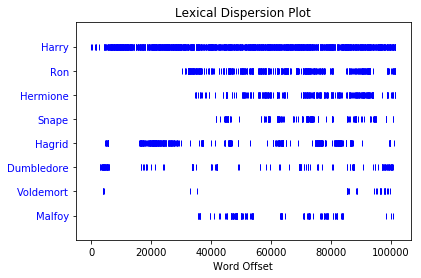

In [12]:
sns.reset_orig() #Seaborn messes with this plot, disabling it
stText.dispersion_plot(['Harry', 'Ron', 'Hermione', 'Snape', 'Hagrid', 'Dumbledore', 'Voldemort', 'Malfoy'])
sns.set() #Re-enabling seaborn

In [14]:
def getGithubFiles(target, maxFiles = 100):
    #We are setting a max so our examples don't take too long to run
    #For converting to a DataFrame
    releasesDict = {
        'name' : [], #The name of the file
        'text' : [], #The text of the file, watch out for binary files
        'path' : [], #The path in the git repo to the file
        'html_url' : [], #The url to see the file on Github
        'download_url' : [], #The url to download the file
    }

    #Get the directory information from Github
    r = requests.get(target)
    filesLst = json.loads(r.text)

    for fileDict in filesLst[:maxFiles]:
        #These are provided by the directory
        releasesDict['name'].append(fileDict['name'])
        releasesDict['path'].append(fileDict['path'])
        releasesDict['html_url'].append(fileDict['html_url'])
        releasesDict['download_url'].append(fileDict['download_url'])

        #We need to download the text though
        text = requests.get(fileDict['download_url']).text
        releasesDict['text'].append(text)

    return pandas.DataFrame(releasesDict)

In [15]:
hpBook = getGithubFiles('https://api.github.com/repos/iminoso/ENGL-108P/contents/dataset', maxFiles = 10)
hpBook[:7]

,download_url,html_url,name,path,text
0,https://raw.githubusercontent.com/iminoso/ENGL...,https://github.com/iminoso/ENGL-108P/blob/mast...,book_1.txt,dataset/book_1.txt,Harry Potter and the Sorcerer’s Stone\n\n\n\nb...
1,https://raw.githubusercontent.com/iminoso/ENGL...,https://github.com/iminoso/ENGL-108P/blob/mast...,book_2.txt,dataset/book_2.txt,Harry Potter and the Chamber of Secrets\n\nby\...
2,https://raw.githubusercontent.com/iminoso/ENGL...,https://github.com/iminoso/ENGL-108P/blob/mast...,book_3.txt,dataset/book_3.txt,Harry Potter and the Prisoner of Azkaban\n\nby...
3,https://raw.githubusercontent.com/iminoso/ENGL...,https://github.com/iminoso/ENGL-108P/blob/mast...,book_4.txt,dataset/book_4.txt,Harry Potter and the Goblet Of Fire\n\nby\n\nJ...
4,https://raw.githubusercontent.com/iminoso/ENGL...,https://github.com/iminoso/ENGL-108P/blob/mast...,book_5.txt,dataset/book_5.txt,Harry Potter and the Order of the Phoenix\n\nb...
5,https://raw.githubusercontent.com/iminoso/ENGL...,https://github.com/iminoso/ENGL-108P/blob/mast...,book_6.txt,dataset/book_6.txt,Harry Potter and the Half-Blood Prince\n\nby\n...
6,https://raw.githubusercontent.com/iminoso/ENGL...,https://github.com/iminoso/ENGL-108P/blob/mast...,book_7.txt,dataset/book_7.txt,Harry Potter and the Deathly Hallows\n\nby\n\n...


In [16]:
hpBook['tokenized_text'] = hpBook['text'].apply(lambda x: nltk.word_tokenize(x))

# Filtering and normalizing text

As we want to start comparing the different releases we may choose to do a bit of filtering and normalizing that will allow us to focus on what we most care about. We can first make all of the words lower case, then drop the non-word tokens. Next, we can remove some 'stop words', stem the remaining words to remove suffixes, prefixes and (in some languages) infixes, or lemmatize tokens by intelligently grouping inflected or variant forms of the same word (e.g., with a stemmer and a dictionary). 

To begin this process, we will first define a function to work over the tokenized lists, then another to add normalized tokens to a new column.

Nltk has a built-in list of stopwords. They are already imported in the import section. Let's first take a look at what they are.

In [86]:
print(', '.join(stopwords.words('english')))

i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, had, having, do, does, did, doing, a, an, the, and, but, if, or, because, as, until, while, of, at, by, for, with, about, against, between, into, through, during, before, after, above, below, to, from, up, down, in, out, on, off, over, under, again, further, then, once, here, there, when, where, why, how, all, any, both, each, few, more, most, other, some, such, no, nor, not, only, own, same, so, than, too, very, s, t, can, will, just, don, don't, should, should've, now, d, ll, m, o, re, ve, y, ain, aren, aren't, couldn, couldn't, didn, didn't, doesn, doesn't, hadn, hadn't, hasn, hasn't, haven, haven't, isn, isn't, ma, mightn, mightn't, mustn, must

We can remove these stopwords from the analysis by fiat, but we could also take a more principled approach by looking at the frequency distribution of words and selecting a specific cut-off associated with the preservation of 'meaningful words' identified upon inspection. Alternatively, we could automatically set a cut-off by rule, such as removal of all words more frequent then the most frequent verb, or the most frequent noun (not pronoun), or some term of central interest. 

Lets generate our own stop list now.

In [87]:
countsDict = {}
for word in whReleases['tokenized_text'].sum():
    if word in countsDict:
        countsDict[word] += 1
    else:
        countsDict[word] = 1
word_counts = sorted(countsDict.items(), key = lambda x : x[1], reverse = True)
word_counts[:20]

[('the', 179),
 (',', 173),
 ('.', 136),
 ('of', 112),
 ('to', 112),
 ('and', 108),
 ('in', 64),
 ('a', 61),
 ("'s", 50),
 ('that', 41),
 ('our', 39),
 ('for', 35),
 ('on', 33),
 ('is', 33),
 ('Whitehouse', 31),
 ('``', 30),
 ('Iraq', 28),
 ('Bush', 27),
 ('President', 25),
 ('(', 24)]

We can look at this and pick the cutoff, usually it is at the first noun. So we will cut all words before `'Whitehouse'`.

In [88]:
#The stop list is then all words that occur before the first noun
stop_words_freq = []
for word, count in word_counts:
    if word == 'Whitehouse':
        break
    else:
        stop_words_freq.append(word)
stop_words_freq
wordnet = nltk.stem.WordNetLemmatizer()
wordnet.lemmatize('are')

'are'

Now we can create our function to normalize the tokens

In [90]:
stop_words_nltk = stopwords.words('english')
#stop_words = ["the","it","she","he", "a"] #Uncomment this line if you want to use your own list of stopwords.

#The stemmers and lemmers need to be initialized before bing run
porter = nltk.stem.porter.PorterStemmer()
snowball = nltk.stem.snowball.SnowballStemmer('english')
wordnet = nltk.stem.WordNetLemmatizer()

def normlizeTokens(tokenLst, stopwordLst = None, stemmer = None, lemmer = None):
    #We can use a generator here as we just need to iterate over it

    #Lowering the case and removing non-words
    workingIter = (w.lower() for w in tokenLst if w.isalpha())

    #Now we can use the semmer, if provided
    if stemmer is not None:
        workingIter = (stemmer.stem(w) for w in workingIter)
        
    #And the lemmer
    if lemmer is not None:
        workingIter = (lemmer.lemmatize(w) for w in workingIter)
    
    #And remove the stopwords
    if stopwordLst is not None:
        workingIter = (w for w in workingIter if w not in stopwordLst)
    #We will return a list with the stopwords removed
    return list(workingIter)

whReleases['normalized_tokens'] = whReleases['tokenized_text'].apply(lambda x: normlizeTokens(x, stopwordLst = stop_words_nltk, stemmer = porter))

whReleases['normalized_tokens_count'] = whReleases['normalized_tokens'].apply(lambda x: len(x))

whReleases

,download_url,html_url,name,path,text,tokenized_text,word_counts,normalized_tokens,normalized_tokens_count
0,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Apr2007Whitehouse123.txt,raw/Whitehouse/10Apr2007Whitehouse123.txt,SEN. WHITEHOUSE SHARES WESTERLY GIRL'S STORY I...,"[SEN., WHITEHOUSE, SHARES, WESTERLY, GIRL, 'S,...",397,"[whitehous, share, westerli, girl, stori, push...",231
1,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Apr2008Whitehouse2.txt,raw/Whitehouse/10Apr2008Whitehouse2.txt,SEN. WHITEHOUSE SAYS PRESIDENT BUSH MUST BEGIN...,"[SEN., WHITEHOUSE, SAYS, PRESIDENT, BUSH, MUST...",344,"[whitehous, say, presid, bush, must, begin, br...",171
2,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Apr2008Whitehouse3.txt,raw/Whitehouse/10Apr2008Whitehouse3.txt,EPA MUST REVIEW LEGAL PROCESS TO ROOT OUT POLI...,"[EPA, MUST, REVIEW, LEGAL, PROCESS, TO, ROOT, ...",553,"[epa, must, review, legal, process, root, poli...",305
3,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Aug2007Whitehouse78.txt,raw/Whitehouse/10Aug2007Whitehouse78.txt,R.I. SENATORS PRAISE SEN. DENIAL OF LNG FACILI...,"[R.I, ., SENATORS, PRAISE, SEN, ., DENIAL, OF,...",216,"[senat, prais, sen, denial, lng, facil, permit...",115
4,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Jan2008Whitehouse35.txt,raw/Whitehouse/10Jan2008Whitehouse35.txt,SEN. WHITEHOUSE COMMENTS ON ONE-YEAR ANNIVERSA...,"[SEN., WHITEHOUSE, COMMENTS, ON, ONE-YEAR, ANN...",257,"[whitehous, comment, anniversari, presid, bush...",132
5,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Mar2008Whitehouse8.txt,raw/Whitehouse/10Mar2008Whitehouse8.txt,"SENS. REED, WHITEHOUSE WELCOME RHODE ISLAND ST...","[SENS, ., REED, ,, WHITEHOUSE, WELCOME, RHODE,...",380,"[sen, reed, whitehous, welcom, rhode, island, ...",195
6,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Sep2007Whitehouse72.txt,raw/Whitehouse/10Sep2007Whitehouse72.txt,REP. WHITEHOUSE ISSUES STATEMENT ON GEN. PETRA...,"[REP., WHITEHOUSE, ISSUES, STATEMENT, ON, GEN....",270,"[whitehous, issu, statement, petraeu, iraq, re...",118
7,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,11Apr2007Whitehouse122.txt,raw/Whitehouse/11Apr2007Whitehouse122.txt,SEN. WHITEHOUSE URGES BUSH FOR NEW DIRECTION I...,"[SEN., WHITEHOUSE, URGES, BUSH, FOR, NEW, DIRE...",521,"[whitehous, urg, bush, new, direct, iraq, shel...",257
8,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,11Jan2007Whitehouse161.txt,raw/Whitehouse/11Jan2007Whitehouse161.txt,"SENS. REED, WHITEHOUSE URGE PORTUGAL TO RECONS...","[SENS, ., REED, ,, WHITEHOUSE, URGE, PORTUGAL,...",484,"[sen, reed, whitehous, urg, portug, reconsid, ...",254
9,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,11Mar2008Whitehouse7.txt,raw/Whitehouse/11Mar2008Whitehouse7.txt,WHITEHOUSE UNVEILS 'BUSH DEBT': $7.7 TRILLION ...,"[WHITEHOUSE, UNVEILS, 'BUSH, DEBT, ', :, $, 7....",482,"[whitehous, unveil, debt, trillion, foregon, s...",260


The stemmer we use here is called the [Porter Stemmer](http://www.nltk.org/api/nltk.stem.html#module-nltk.stem.porter), there are many others, including another good one by the same person (Martin Porter) called the [Snowball Stemmer](http://www.nltk.org/api/nltk.stem.html#module-nltk.stem.snowball) or 'another stemmer' called the [Lancaster Stemmer](http://www.nltk.org/_modules/nltk/stem/lancaster.html). We can also normalize our words by lemmatizing them, or matching word variants or inflected forms to a common morpheme in a dictionary like [WordNet](https://wordnet.princeton.edu) through intelligent stemming rules. (The WordNet function `morphy` returns the given word if it cannot be matched to a word in the dictionary).

Now that it is cleaned we start analyzing the dataset. We can start by finding frequency distributions for the dataset. Lets start looking at all the press releases together. The [`ConditionalFreqDist`](http://www.nltk.org/api/nltk.html#nltk.probability.ConditionalProbDist) class reads in an iterable of tuples, the first element is the condition and the second the focal word. For starters, we will use word lengths as the conditions, but tags or clusters will provide more useful results.

In [91]:
#.sum() adds together the lists from each row into a single list
whcfdist = nltk.ConditionalFreqDist(((len(w), w) for w in whReleases['normalized_tokens'].sum()))

#print the number of words
print(whcfdist.N())

2038


From this we can lookup the distributions of different word lengths

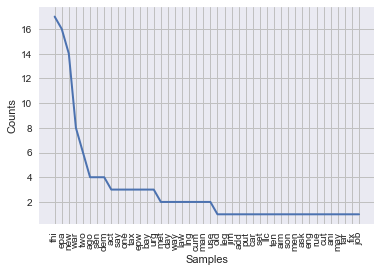

In [92]:
whcfdist[3].plot()

See that the most frequent 3-character word is "thi". But what is "thi"? It is actually "this" stemmed by the Porter Stemmer. 

In [93]:
porter = nltk.stem.porter.PorterStemmer()
print (porter.stem('this'))

thi


Let's try with the Snowball Stemer. See that "this" is corretly stemmed as a 4-character word. 

this


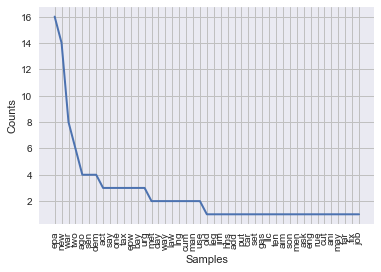

In [94]:
print (snowball.stem('this'))

whReleases['normalized_tokens'] = whReleases['tokenized_text'].apply(lambda x: normlizeTokens(x, stopwordLst = stop_words_nltk, stemmer = snowball))
whReleases['normalized_tokens_count'] = whReleases['normalized_tokens'].apply(lambda x: len(x))
whcfdist = nltk.ConditionalFreqDist(((len(w), w) for w in whReleases['normalized_tokens'].sum()))
whcfdist[3].plot()

We can also create a Conditional Probability Distribution or [`ConditionalProbDist`](http://www.nltk.org/api/nltk.html#nltk.probability.ConditionalProbDist) from the `ConditionalFreqDist`. To do this, however, we need a model for the probability distribution. A simple model is [`ELEProbDist`](http://www.nltk.org/api/nltk.html#nltk.probability.ELEProbDist) which gives the expected likelihood estimate for the probability distribution of the experiment used to generate the observed frequency distribution. 

In [95]:
whcpdist = nltk.ConditionalProbDist(whcfdist, nltk.ELEProbDist)

#print the most common 2 letter word
print(whcpdist[2].max())

#And its probability
print(whcpdist[2].prob(whcpdist[2].max()))

us
0.6470588235294118


Length is one feature of a word, but there are many more important features we care about. Another critical feature is a word's role in the sentence, or its part of speech (POS). Here, we will be classifying words according to their part of speech (POS), using the [`nltk.pos_tag()`](http://www.nltk.org/api/nltk.tag.html#nltk.tag.pos_tag). The tags used here are those from the [Brown Corpus tagset](http://www.scs.leeds.ac.uk/amalgam/tagsets/brown.html).

In [96]:
whReleases['normalized_tokens_POS'] = [nltk.pos_tag(t) for t in whReleases['normalized_tokens']]

This gives us a new column with the part of speech as a short initialism and the word in a tuple, exactly how the `nltk.ConditionalFreqDist()` function wants them. We can now construct another conditional frequency distribution.

In [97]:
whcfdist_WordtoPOS = nltk.ConditionalFreqDist(whReleases['normalized_tokens_POS'].sum())
list(whcfdist_WordtoPOS.items())[:10]

[('whitehous', FreqDist({'JJ': 39, 'NN': 1})),
 ('share', FreqDist({'NN': 4})),
 ('wester', FreqDist({'NN': 1, 'RBR': 1})),
 ('girl', FreqDist({'NN': 2})),
 ('stori', FreqDist({'FW': 2})),
 ('push', FreqDist({'NN': 2})),
 ('stem', FreqDist({'NN': 12})),
 ('cell', FreqDist({'NN': 9, 'VBP': 3})),
 ('research', FreqDist({'NN': 9})),
 ('lila', FreqDist({'CD': 1, 'JJ': 1, 'NN': 2}))]

This gives the frequency of each word as each part of speech...which can be uninformative and boring.

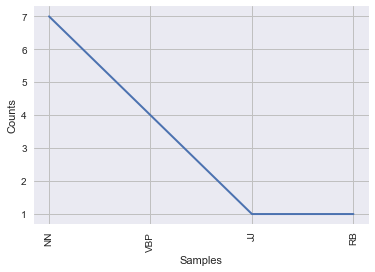

In [98]:
whcfdist_WordtoPOS['administr'].plot()

What we want is the converse; the frequency of each part of speech for each word.

In [99]:
whcfdist_POStoWord = nltk.ConditionalFreqDist((p, w) for w, p in whReleases['normalized_tokens_POS'].sum())

We can now identify and collect all of the superlative adjectives

In [100]:
whcfdist_POStoWord['JJS']

FreqDist({'best': 1, 'strongest': 2})

Or look at the most common nouns

In [101]:
whcfdist_POStoWord['NN'].most_common(5)

[('bush', 24), ('presid', 23), ('iraq', 22), ('rhode', 18), ('island', 18)]

Or plot the base form verbs against their number of occurrences

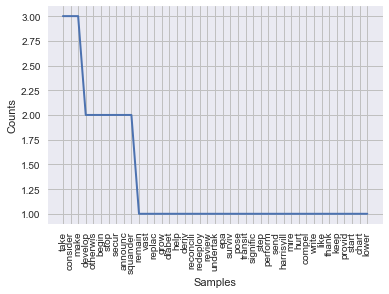

In [102]:
whcfdist_POStoWord['VB'].plot()

We can then do a similar analysis of the word probabilities

In [103]:
whcpdist_POStoWord = nltk.ConditionalProbDist(whcfdist_POStoWord, nltk.ELEProbDist)

#print the most common nouns
print(whcpdist_POStoWord['NN'].max())

#And its probability
print(whcpdist_POStoWord['NN'].prob(whcpdist_POStoWord['NN'].max()))

bush
0.017844136926438457


We can even create a...wait for it...*WORD CLOUD* or Wordl to gaze at and draw mystical, approximate inferences about important nouns and verbs in our corpus:

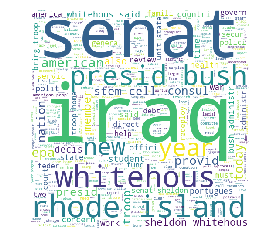

In [104]:
wc = wordcloud.WordCloud(background_color="white", max_words=500, width= 1000, height = 1000, mode ='RGBA', scale=.5).generate(' '.join(whReleases['normalized_tokens'].sum()))
plt.imshow(wc)
plt.axis("off")
plt.savefig("whitehouse_word_cloud.pdf", format = 'pdf')

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">Construct cells immediately below this that filter, stem and lemmatize the tokens in your corpus, and then creates plots (with titles and labels) that map the word frequency distribution, word probability distribution, and at least two conditional probability distributions that help us better understand the social and cultural game underlying the production of your corpus. Create a wordl of words (or normalized words) and add a few vague comments about what mysteries are revealed through it.</span>

In [17]:
countsDict = {}
for word in hpBook['tokenized_text'].sum():
    if word in countsDict:
        countsDict[word] += 1
    else:
        countsDict[word] = 1
word_counts = sorted(countsDict.items(), key = lambda x : x[1], reverse = True)
word_counts[:20]

[(',', 86288),
 ('.', 56839),
 ('the', 47854),
 ('“', 37059),
 ('”', 36723),
 ('’', 34959),
 ('to', 26670),
 ('and', 25742),
 ('of', 21615),
 ('a', 19956),
 ('Harry', 18118),
 ('he', 16057),
 ('was', 15521),
 ('s', 14649),
 ('said', 14468),
 ('his', 13712),
 ('I', 13549),
 ('in', 12339),
 ('you', 11660),
 ('it', 11576)]

In [20]:
#The stop list is then all words that occur before the first noun
stop_words_freq = []
for word, count in word_counts:
    if word == 'Harry':
        break
    else:
        stop_words_freq.append(word)
stop_words_freq
wordnet = nltk.stem.WordNetLemmatizer()
wordnet.lemmatize('are')

'are'

Now we can create our function to normalize the tokens

In [22]:
stop_words_nltk = stopwords.words('english')
#stop_words = ["the","it","she","he", "a"] #Uncomment this line if you want to use your own list of stopwords.

#The stemmers and lemmers need to be initialized before bing run
porter = nltk.stem.porter.PorterStemmer()
snowball = nltk.stem.snowball.SnowballStemmer('english')
wordnet = nltk.stem.WordNetLemmatizer()

def normlizeTokens(tokenLst, stopwordLst = None, stemmer = None, lemmer = None):
    #We can use a generator here as we just need to iterate over it

    #Lowering the case and removing non-words
    workingIter = (w.lower() for w in tokenLst if w.isalpha())

    #Now we can use the semmer, if provided
    if stemmer is not None:
        workingIter = (stemmer.stem(w) for w in workingIter)
        
    #And the lemmer
    if lemmer is not None:
        workingIter = (lemmer.lemmatize(w) for w in workingIter)
    
    #And remove the stopwords
    if stopwordLst is not None:
        workingIter = (w for w in workingIter if w not in stopwordLst)
    #We will return a list with the stopwords removed
    return list(workingIter)

hpBook['normalized_tokens'] = hpBook['tokenized_text'].apply(lambda x: normlizeTokens(x, stopwordLst = stop_words_nltk, stemmer = porter))

hpBook['normalized_tokens_count'] = hpBook['normalized_tokens'].apply(lambda x: len(x))


In [23]:
#.sum() adds together the lists from each row into a single list
hpcfdist = nltk.ConditionalFreqDist(((len(w), w) for w in hpBook['normalized_tokens'].sum()))

#print the number of words
print(hpcfdist.N())

593999


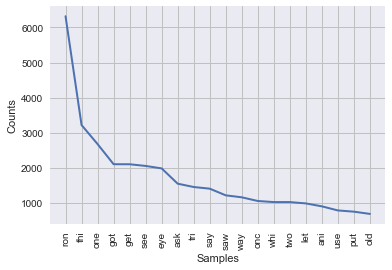

In [65]:
hpcfdist[3].plot(20)

In [25]:
hpcpdist = nltk.ConditionalProbDist(hpcfdist, nltk.ELEProbDist)

#print the most common 4 letter word
print(hpcpdist[4].max())

#And its probability
print(hpcpdist[4].prob(hpcpdist[4].max()))

said
0.08032479215353609


In [26]:
hpBook['normalized_tokens_POS'] = [nltk.pos_tag(t) for t in hpBook['normalized_tokens']]

In [27]:
hpcfdist_WordtoPOS = nltk.ConditionalFreqDist(hpBook['normalized_tokens_POS'].sum())
list(hpcfdist_WordtoPOS.items())[:10]

[('harri',
  FreqDist({'CD': 1,
            'EX': 1,
            'FW': 2,
            'IN': 1,
            'JJ': 4368,
            'JJR': 9,
            'NN': 12615,
            'NNS': 191,
            'PRP': 15,
            'PRP$': 21,
            'RB': 186,
            'RBR': 10,
            'RBS': 1,
            'VB': 166,
            'VBD': 206,
            'VBN': 47,
            'VBP': 234,
            'VBZ': 93})),
 ('potter',
  FreqDist({'JJ': 37,
            'JJR': 8,
            'NN': 1052,
            'NNS': 1,
            'RB': 46,
            'RBR': 2,
            'VB': 7,
            'VBP': 11})),
 ('sorcer', FreqDist({'JJ': 2, 'NN': 32, 'RB': 1, 'VBN': 1})),
 ('stone',
  FreqDist({'CD': 5,
            'JJ': 76,
            'NN': 320,
            'RB': 5,
            'VB': 3,
            'VBN': 1,
            'VBP': 1})),
 ('rowl', FreqDist({'NN': 30})),
 ('illustr', FreqDist({'NN': 19})),
 ('mari', FreqDist({'FW': 1, 'JJ': 3, 'NN': 16})),
 ('grandpré', FreqDist({'NN': 13}

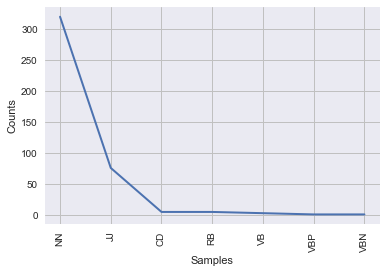

In [29]:
hpcfdist_WordtoPOS['stone'].plot()

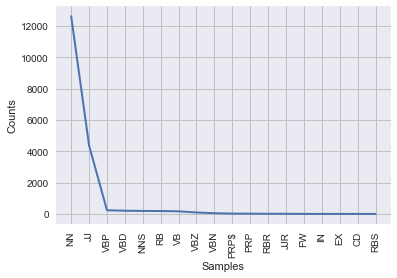

In [30]:
hpcfdist_WordtoPOS['harri'].plot()

In [31]:
hpcfdist_POStoWord = nltk.ConditionalFreqDist((p, w) for w, p in hpBook['normalized_tokens_POS'].sum())

In [32]:
hpcfdist_POStoWord['JJ'].most_common(10)

[('harri', 4368),
 ('hi', 3625),
 ('wa', 2806),
 ('hagrid', 1427),
 ('open', 1183),
 ('last', 1070),
 ('good', 945),
 ('black', 945),
 ('thi', 921),
 ('great', 854)]

In [33]:
hpcfdist_POStoWord['NN'].most_common(10)

[('harri', 12615),
 ('wa', 9940),
 ('hi', 9880),
 ('ron', 5622),
 ('hermion', 5205),
 ('look', 4121),
 ('dumbledor', 2548),
 ('eye', 1988),
 ('hand', 1903),
 ('time', 1894)]

We can then do a similar analysis of the word probabilities

In [34]:
hpcpdist_POStoWord = nltk.ConditionalProbDist(hpcfdist_POStoWord, nltk.ELEProbDist)

print(hpcpdist_POStoWord['RB'].max())

#And its probability
print(hpcpdist_POStoWord['RB'].prob(hpcpdist_POStoWord['RB'].max()))

back
0.11248262127531658


In [37]:
print(hpcpdist_POStoWord['VB'].max())

#And its probability
print(hpcpdist_POStoWord['VB'].prob(hpcpdist_POStoWord['VB'].max()))

get
0.05894889925279575


In [39]:
wc_hp = wordcloud.WordCloud(background_color="white", max_words=500, width= 1000, height = 1000, mode ='RGBA', scale=.5).generate(' '.join(hpBook['normalized_tokens'].sum()))
plt.imshow(wc_hp)

plt.axis("off")
plt.savefig("harrypotter_word_cloud.pdf", format = 'pdf')

Remarks:
There is no doubt that Harry would be the most frequent noun. But "harri" is also the most frequent adjective, does this "harri" the token of Harry? It is interesting that the most frequent adverb is back and the most frequent verb is get. 

# Collocations

As illustrated above, we might want to find significant bigrams (two-word phrases), trigrams (three-word phrases), n-grams (*n*-word phrases) or skip-grams (noncontinguous 'phrases' with skip-length *n*). We will begin with the [`nltk.collocations.BigramCollocationFinder`](http://www.nltk.org/api/nltk.html?highlight=bigramcollocationfinder#nltk.collocations.BigramCollocationFinder) class, which can be given raw lists of strings with the `from_words()` method. By default it only looks at continuous bigrams but there is an option (`window_size`) to allow skip-grams.

In [139]:
whBigrams = nltk.collocations.BigramCollocationFinder.from_words(whReleases['normalized_tokens'].sum())
print("There are {} bigrams in the finder".format(whBigrams.N))

There are 1999 bigrams in the finder


To compare the bigrams we need to tell nltk what our score function is. Initially, we will look at the raw counts.

In [141]:
def bigramScoring(count, wordsTuple, total):
    return count

print(whBigrams.nbest(bigramScoring, 10))

[('rhode', 'island'), ('presid', 'bush'), ('sheldon', 'whitehous'), ('stem', 'cell'), ('whitehous', 'said'), ('bush', 'administr'), ('american', 'peopl'), ('bring', 'troop'), ('senat', 'sheldon'), ('troop', 'home')]


One note about how `BigramCollocationFinder` works. It doesn't use the strings internally.

In [142]:
birgramScores = []

def bigramPrinting(count, wordsTuple, total):
    global birgramScores
    birgramScores.append("The first word is:  {}, The second word is: {}".format(*wordsTuple))
    #Returns None so all the tuples are considered to have the same rank

whBigrams.nbest(bigramPrinting, 10)
print('\n'.join(birgramScores[:10]))

The first word is:  40, The second word is: 4
The first word is:  4, The second word is: 2
The first word is:  2, The second word is: 2
The first word is:  2, The second word is: 2
The first word is:  2, The second word is: 2
The first word is:  2, The second word is: 12
The first word is:  12, The second word is: 12
The first word is:  12, The second word is: 9
The first word is:  9, The second word is: 4
The first word is:  4, The second word is: 2


The words are each given numeric IDs and there is a dictionary that maps the IDs to the words they represent. This is a common performance optimization.

Two words can appear together by chance. Recall from  Manning and Schütze's textbook that a $t-value can be computed for each bigram to see how significant the association is. You may also want to try computing the $\chi^2$, likelihood ratio, and pointwise mutual information statistics. 

In [144]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
whBigrams.score_ngrams(bigram_measures.likelihood_ratio)[:40]
# other options include student_t, chi_sq, likelihood_ratio, pmi

[(('rhode', 'island'), 223.98603169548517),
 (('stem', 'cell'), 146.69971583676724),
 (('presid', 'bush'), 124.78339903371592),
 (('sheldon', 'whitehous'), 97.83057167237577),
 (('unit', 'state'), 63.7408597571739),
 (('whitehous', 'said'), 50.85365409523493),
 (('jack', 'reed'), 46.61449955206517),
 (('honor', 'societi'), 45.00623576992483),
 (('american', 'peopl'), 44.4949166648486),
 (('bring', 'troop'), 43.29082241816299),
 (('bush', 'administr'), 42.73672706610401),
 (('cell', 'research'), 41.25934273451902),
 (('youth', 'program'), 38.276119099832265),
 (('troop', 'home'), 36.87601441962918),
 (('come', 'home'), 36.661589434392276),
 (('senat', 'sheldon'), 36.08708619238288),
 (('epw', 'committe'), 34.42122395939712),
 (('potenti', 'close'), 33.7794434582587),
 (('budget', 'resolut'), 32.192797473966614),
 (('district', 'columbia'), 31.62701894759353),
 (('humpti', 'dumpti'), 31.62701894759353),
 (('jose', 'socrat'), 31.62701894759353),
 (('prime', 'minist'), 31.62701894759353),


There are a few other available measures

In [145]:
[s for s in dir(bigram_measures) if s[0] != '_']

['chi_sq',
 'dice',
 'fisher',
 'jaccard',
 'likelihood_ratio',
 'mi_like',
 'phi_sq',
 'pmi',
 'poisson_stirling',
 'raw_freq',
 'student_t']

We can also look at trigrams

In [146]:
trigram_measures = nltk.collocations.TrigramAssocMeasures()
whTrigrams = nltk.collocations.TrigramCollocationFinder.from_words(whReleases['normalized_tokens'].sum())
whTrigrams.score_ngrams(trigram_measures.student_t)[:20]

[(('bring', 'troop', 'home'), 2.449202865677887),
 (('senat', 'sheldon', 'whitehous'), 2.4481166557834917),
 (('stem', 'cell', 'research'), 2.2359229352888974),
 (('whitehous', 'said', 'today'), 1.9987987990993996),
 (('jack', 'reed', 'sheldon'), 1.7319953264758123),
 (('senat', 'youth', 'program'), 1.7319901251233376),
 (('unit', 'state', 'senat'), 1.73173525885207),
 (('new', 'direct', 'iraq'), 1.7316624399174225),
 (('reed', 'sheldon', 'whitehous'), 1.7314959966382275),
 (('sheldon', 'whitehous', 'said'), 1.7309411857075774),
 (('trillion', 'foregon', 'surplus'), 1.414209315486583),
 (('reconsid', 'potenti', 'close'), 1.4142064842289084),
 (('sent', 'clear', 'messag'), 1.414205599460885),
 (('today', 'confirm', 'hear'), 1.4141976365486753),
 (('select', 'committe', 'intellig'), 1.4141965748270473),
 (('general', 'david', 'petraeus'), 1.4141923279405353),
 (('take', 'respons', 'secur'), 1.4141923279405353),
 (('cell', 'enhanc', 'act'), 1.4141880810540235),
 (('respons', 'secur', 'gov

Or n-grams (for any number n)

In [147]:
Ngrams = nltk.ngrams(whReleases['normalized_tokens'].sum(), 4)
Counts = {}
for ngram in list(Ngrams):
    if ngram in Counts.keys():
        Counts[ngram] += 1
    else:
        Counts[ngram] = 1
Filtered = {}
for key in Counts.keys():
    if Counts[key] < 2:
        pass
    else:
        Filtered[key] = Counts[key]
print(Filtered)

{('stem', 'cell', 'research', 'whitehous'): 2, ('stem', 'cell', 'enhanc', 'act'): 2, ('begin', 'bring', 'troop', 'home'): 2, ('bring', 'troop', 'home', 'iraq'): 2, ('senat', 'sheldon', 'whitehous', 'said'): 3, ('sheldon', 'whitehous', 'said', 'today'): 3, ('member', 'senat', 'select', 'committe'): 2, ('senat', 'select', 'committe', 'intellig'): 2, ('take', 'respons', 'secur', 'govern'): 2, ('senat', 'jack', 'reed', 'sheldon'): 2, ('jack', 'reed', 'sheldon', 'whitehous'): 3, ('whitehous', 'welcom', 'rhode', 'island'): 2, ('portugues', 'american', 'citizen', 'rhode'): 2, ('american', 'citizen', 'rhode', 'island'): 2}


## <span style="color:red">*Exercise 3*</span>

<span style="color:red">Construct cells immediately below this that identify statistically significant bigrams, trigrams, quadgrams, higher-order *n*grams and skipgrams. Explore whether these collocations are idiomatic and so irreducible to the semantic sum of their component words. You can do this by examination of conditional frequencies (e.g., what else is 'united' besides the 'United States'). If these phrases are idiomatic, what do they suggest about the culture of the world producing them?

<span style="color:red">**Stretch**: In Manning and Schütze's textbook, there Section 5.3.2 explores how to use the *t*-test to find words whose co-occurance patterns best distinguish two words. Implement that and use it to explore phrases in your corpus. For instance, you could tell what words come after "America" much more often than after "Iraq"?</span> 

In [40]:
hpBigrams = nltk.collocations.BigramCollocationFinder.from_words(hpBook['normalized_tokens'].sum())
print("There are {} bigrams in the finder".format(hpBigrams.N))

There are 593999 bigrams in the finder


In [41]:
def bigramScoring(count, wordsTuple, total):
    return count

print(hpBigrams.nbest(bigramScoring, 10))

[('said', 'harri'), ('said', 'ron'), ('said', 'hermion'), ('ron', 'hermion'), ('harri', 'wa'), ('hi', 'wand'), ('harri', 'said'), ('harri', 'ron'), ('said', 'dumbledor'), ('hi', 'eye')]


One note about how `BigramCollocationFinder` works. It doesn't use the strings internally.

In [42]:
birgramScores = []

def bigramPrinting(count, wordsTuple, total):
    global birgramScores
    birgramScores.append("The first word is:  {}, The second word is: {}".format(*wordsTuple))
    #Returns None so all the tuples are considered to have the same rank

hpBigrams.nbest(bigramPrinting, 10)
print('\n'.join(birgramScores[:10]))

The first word is:  18167, The second word is: 1164
The first word is:  1164, The second word is: 36
The first word is:  36, The second word is: 411
The first word is:  411, The second word is: 30
The first word is:  30, The second word is: 19
The first word is:  19, The second word is: 20
The first word is:  20, The second word is: 13
The first word is:  13, The second word is: 157
The first word is:  157, The second word is: 9
The first word is:  9, The second word is: 565


In [43]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
hpBigrams.score_ngrams(bigram_measures.likelihood_ratio)[:40]
# other options include student_t, chi_sq, likelihood_ratio, pmi

[(('death', 'eater'), 7335.92248061874),
 (('uncl', 'vernon'), 6366.083715972587),
 (('professor', 'mcgonagal'), 6294.3011262987075),
 (('said', 'harri'), 6006.814759778711),
 (('said', 'ron'), 5098.117076798313),
 (('fred', 'georg'), 4057.110146230993),
 (('said', 'hermion'), 3859.210953327987),
 (('aunt', 'petunia'), 3229.3365503539235),
 (('hi', 'wand'), 3021.70164533359),
 (('ron', 'hermion'), 2871.2124116268687),
 (('common', 'room'), 2608.989706935989),
 (('hi', 'eye'), 2262.916400981219),
 (('invis', 'cloak'), 2246.825641077301),
 (('crabb', 'goyl'), 2237.5798487303764),
 (('hi', 'head'), 2217.2426617543492),
 (('madam', 'pomfrey'), 2217.2046841672523),
 (('professor', 'trelawney'), 2216.9724167026834),
 (('daili', 'prophet'), 2202.3194889222323),
 (('dark', 'art'), 2023.8710804789043),
 (('great', 'hall'), 1970.5681659142879),
 (('look', 'around'), 1876.85360727423),
 (('hi', 'hand'), 1874.0969073636184),
 (('said', 'dumbledor'), 1688.3996320789176),
 (('entranc', 'hall'), 1676

Trigrams

In [44]:
trigram_measures = nltk.collocations.TrigramAssocMeasures()
hpTrigrams = nltk.collocations.TrigramCollocationFinder.from_words(hpBook['normalized_tokens'].sum())
hpTrigrams.score_ngrams(trigram_measures.student_t)[:20]

[(('harri', 'ron', 'hermion'), 15.987383128690025),
 (('said', 'professor', 'mcgonagal'), 12.445507252446388),
 (('defens', 'dark', 'art'), 10.770316533436857),
 (('harri', 'could', 'see'), 10.742201389767352),
 (('yeah', 'said', 'harri'), 10.48552787206404),
 (('rais', 'hi', 'wand'), 9.793909047947345),
 (('harri', 'look', 'around'), 9.680393915013402),
 (('shook', 'hi', 'head'), 9.217871344814876),
 (('ye', 'said', 'harri'), 9.037646722675282),
 (('said', 'ron', 'look'), 9.007052115306577),
 (('said', 'hermion', 'look'), 8.521344241515205),
 (('right', 'said', 'harri'), 8.51813784614707),
 (('nearli', 'headless', 'nick'), 8.426148440732337),
 (('point', 'hi', 'wand'), 8.237321996890504),
 (('open', 'hi', 'eye'), 7.987835779244232),
 (('harri', 'said', 'hermion'), 7.961664297310907),
 (('got', 'hi', 'feet'), 7.929163563800131),
 (('said', 'harri', 'quickli'), 7.89693794901704),
 (('said', 'uncl', 'vernon'), 7.872632987138715),
 (('harri', 'wa', 'sure'), 7.324650183761061)]

Or n-grams (for any number n)

In [45]:
Ngrams = nltk.ngrams(hpBook['normalized_tokens'].sum(), 4)
Counts = {}
for ngram in list(Ngrams):
    if ngram in Counts.keys():
        Counts[ngram] += 1
    else:
        Counts[ngram] = 1
Filtered = {}
for key in Counts.keys():
    if Counts[key] < 2:
        pass
    else:
        Filtered[key] = Counts[key]
print(Filtered)

{('harri', 'potter', 'sorcer', 'stone'): 2, ('potter', 'sorcer', 'stone', 'rowl'): 2, ('rowl', 'illustr', 'mari', 'grandpré'): 13, ('illustr', 'mari', 'grandpré', 'arthur'): 7, ('mari', 'grandpré', 'arthur', 'levin'): 7, ('grandpré', 'arthur', 'levin', 'book'): 7, ('arthur', 'levin', 'book', 'imprint'): 9, ('levin', 'book', 'imprint', 'scholast'): 9, ('book', 'imprint', 'scholast', 'press'): 7, ('text', 'copyright', 'rowl', 'illustr'): 7, ('copyright', 'rowl', 'illustr', 'mari'): 7, ('illustr', 'mari', 'grandpré', 'copyright'): 6, ('mari', 'grandpré', 'copyright', 'warner'): 6, ('grandpré', 'copyright', 'warner', 'right'): 3, ('copyright', 'warner', 'right', 'reserv'): 4, ('warner', 'right', 'reserv', 'publish'): 4, ('right', 'reserv', 'publish', 'scholast'): 5, ('reserv', 'publish', 'scholast', 'press'): 5, ('publish', 'scholast', 'press', 'divis'): 5, ('scholast', 'press', 'divis', 'scholast'): 5, ('press', 'divis', 'scholast', 'publish'): 5, ('divis', 'scholast', 'publish', 'sinc'):

Remarks:
The book is kind of male-dominated for the most trigrams appear are about "his" properties, such as his eye, his wand, or his head. Though the book is about Harry Potter, but is not all about him. Harry Potter is actually not the bigram that has the highest likehood ratio, the highest is death eater.

# Distributional distances

If we want to compare different corpora, we need a distance or divergence that compares the two distributions.

We will use the: 

+ Kullback-Leibler (KL) divergence
+ $\chi^2$ divergence
+ Kolmogorov-Smirnov (KS) distance
+ Wasserstein distance

### Kullback-Leibler and $x^2$ divergences ###

KL and $\chi^2$ divergences are members of the broader <a "href=https://en.wikipedia.org/wiki/F-divergence" target="_blank">$f$-divergence</a> family, a function of $D_f (P || Q)$ that calculates the difference between two probability distributions P and Q. The KL $f(t)$ is $ t \text{ log } t $, while the $\chi^2$ is $t^2-1$. KL comes from information and $\chi^2$ from measure theory. As such, the KL divergence computes the relative entropy between two distributions--how they differ in bits, while the $\chi^2$ whether the same statistical inferences can be drawn from them both.  

Specifically, given two discrete probability distributions $P$ and $Q$, the Kullback-Leibler divergence from $Q$ to $P$ is defined as:

$D_{\mathrm{KL}}(P\|Q) = \sum_i P(i) \, \log\frac{P(i)}{Q(i)}$.

The [scipy.stats.entropy()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.entropy.html) function does the calculation for you, which takes in two arrays of probabilities and computes the KL divergence. Note that the KL divergence is in general not commutative, i.e. $D_{\mathrm{KL}}(P\|Q) \neq D_{\mathrm{KL}}(Q\|P)$ .

Also note that the KL divernce is the sum of elementwise divergences. Scipy provides [scipy.special.kl_div()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.kl_div.html#scipy-special-kl-div) which calculates elementwise divergences for you.

The $\chi^2$ Divergence is defined as:

$D_{\mathrm{\chi^2}}(P\|Q) = \sum_i \left(\frac{P(i)}{Q(i)}-1\right)^2$. 

This is also noncommutative, and the code can be drawn directly from scipy.

### Kolmogorov-Smirnov ###

The two-sample Kolmogovorov-Smirnov test statistic calculates the distance between the cumulative distribution function of the two distributions to be compared, and, along with the $x^2$ divergence, is among the most common approaches two calculating a distance in statistics. It can be interpreted as a test of whether two distributions are drawn from the same underlying distribution. As with the others, the code is readily available in scipy.

### Wasserstein Distance ###

When this is computed on a Euclidian metric structure (e.g., numbers of words), this is also known as the earth mover’s distance, because it can be seen as the minimum amount of "work" required to transform $P$ into $Q$, where "work" is measured as the amount of distribution weight that must be moved, multiplied by the distance it has to be moved.

### Computing ###

To do this we will need to create the arrays, lets compare the Whitehouse releases with the Kennedy releases. First we have to download them and load them into a DataFrame.

In [165]:
kenReleases = getGithubFiles('https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Kennedy', maxFiles = 10)
kenReleases[:5]

,download_url,html_url,name,path,text
0,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Apr2005Kennedy14.txt,raw/Kennedy/01Apr2005Kennedy14.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...
1,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2005Kennedy12.txt,raw/Kennedy/01Aug2005Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...
2,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy10.txt,raw/Kennedy/01Aug2006Kennedy10.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...
3,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy11.txt,raw/Kennedy/01Aug2006Kennedy11.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...
4,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy12.txt,raw/Kennedy/01Aug2006Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...


Then we can tokenize, stem and remove stop words, like we did for the Whitehouse press releases

In [166]:
kenReleases['tokenized_text'] = kenReleases['text'].apply(lambda x: nltk.word_tokenize(x))
kenReleases['normalized_tokens'] = kenReleases['tokenized_text'].apply(lambda x: normlizeTokens(x, stopwordLst = stop_words_nltk, stemmer = snowball))

Now we need to compare the two collection of words, remove those not found in both, and assign the remaining ones indices.

In [167]:
whWords = set(whReleases['normalized_tokens'].sum())
kenWords = set(kenReleases['normalized_tokens'].sum())

#Change & to | if you want to keep all words
overlapWords = whWords & kenWords

overlapWordsDict = {word: index for index, word in enumerate(overlapWords)}
overlapWordsDict['student']

241

Now we can count the occurrences of each word in the corpora and create our arrays. Note that we don't have to use numpy arrays as we do here. We could just use a list, but the arrays are faster in numpy so we encourage you to get in the habit of using them.

In [168]:
def makeProbsArray(dfColumn, overlapDict):
    words = dfColumn.sum()
    countList = [0] * len(overlapDict)
    for word in words:
        try:
            countList[overlapDict[word]] += 1
        except KeyError:
            #The word is not common so we skip it
            pass
    countArray = np.array(countList)
    return countArray / countArray.sum()

whProbArray = makeProbsArray(whReleases['normalized_tokens'], overlapWordsDict)
kenProbArray = makeProbsArray(kenReleases['normalized_tokens'], overlapWordsDict)
kenProbArray.sum()
#There is a little bit of a floating point math error
#but it's too small to see with print and too small matter here

1.0

We can now compute the KL divergence. Pay attention to the asymmetry. Use [the Jensen–Shannon divergence](https://en.wikipedia.org/wiki/Jensen%E2%80%93Shannon_divergence), which is the average KL divergence between each distribution and the average of both distributions (i.e., the midpoint), if you want symmetry.

In [169]:
wh_kenDivergence = scipy.stats.entropy(whProbArray, kenProbArray)
print (wh_kenDivergence)
ken_whDivergence = scipy.stats.entropy(kenProbArray, whProbArray)
print (ken_whDivergence)

0.6176419677476955
0.5877085657188856


Then, we can do the elementwise calculation and see which words best distinguish the two corpora.

In [170]:
wh_kenDivergence_ew = scipy.special.kl_div(whProbArray, kenProbArray)
kl_df = pandas.DataFrame(list(overlapWordsDict.keys()), columns = ['word'], index = list(overlapWordsDict.values()))
kl_df = kl_df.sort_index()
kl_df['elementwise divergence'] = wh_kenDivergence_ew
kl_df[:10]

,word,elementwise divergence
0,continu,0.000731
1,expand,0.002023
2,intent,0.000063
3,job,0.000672
4,person,0.002023
5,oppos,0.000063
6,support,0.002202
7,act,0.001255
8,employ,0.005883
9,peopl,0.008876


In [171]:
kl_df.sort_values(by='elementwise divergence', ascending=False)[:10]

,word,elementwise divergence
143,iraq,0.086929
86,bush,0.042354
58,stem,0.021884
243,law,0.020547
170,protect,0.019358
295,american,0.018154
276,depart,0.017650
34,bring,0.014128
172,member,0.012429
23,war,0.011739


Now we will apply what we learned today to the Guternberg texts in nltk and see if we can detect patterns between them. 

First, let's transform every text into normalized tokens. Note that in this first step, no stopword is removed. 

In [172]:
fileids = nltk.corpus.gutenberg.fileids()
corpora = []
for fileid in fileids:
    words = nltk.corpus.gutenberg.words(fileid)
    normalized_tokens = normlizeTokens(words, stopwordLst = [], stemmer = snowball)
    corpora.append(normalized_tokens)

Then, let's separate the normalized tokens into stopwords and non-stopwords.

In [173]:
corpora_s = []
corpora_nons = []
for corpus in corpora:
    s = []
    nons = []
    for word in corpus:
        if word in stop_words_nltk:
            s.append(word)
        else:
            nons.append(word)
    corpora_s.append(s)
    corpora_nons.append(nons)

Define some covenient funtions for calculating divergence and distances.

In [48]:
def kl_divergence(X, Y):
    P = X.copy()
    Q = Y.copy()
    P.columns = ['P']
    Q.columns = ['Q']
    df = Q.join(P).fillna(0)
    p = df.iloc[:,1]
    q = df.iloc[:,0]
    D_kl = scipy.stats.entropy(p, q)
    return D_kl

def chi2_divergence(X,Y):
    P = X.copy()
    Q = Y.copy()
    P.columns = ['P']
    Q.columns = ['Q']
    df = Q.join(P).fillna(0)
    p = df.iloc[:,1]
    q = df.iloc[:,0]
    return scipy.stats.chisquare(p, q).statistic

def Divergence(corpus1, corpus2, difference="KL"):
    """Difference parameter can equal KL, Chi2, or Wass"""
    freqP = nltk.FreqDist(corpus1)
    P = pandas.DataFrame(list(freqP.values()), columns = ['frequency'], index = list(freqP.keys()))
    freqQ = nltk.FreqDist(corpus2)
    Q = pandas.DataFrame(list(freqQ.values()), columns = ['frequency'], index = list(freqQ.keys()))
    if difference == "KL":
        return kl_divergence(P, Q)
    elif difference == "Chi2":
        return chi2_divergence(P, Q)
    elif difference == "KS":
        try:
            return scipy.stats.ks_2samp(P['frequency'], Q['frequency']).statistic
        except:
            return scipy.stats.ks_2samp(P['frequency'], Q['frequency'])
    elif difference == "Wasserstein":
        try:
            return scipy.stats.wasserstein_distance(P['frequency'], Q['frequency'], u_weights=None, v_weights=None).statistic
        except:
            return scipy.stats.wasserstein_distance(P['frequency'], Q['frequency'], u_weights=None, v_weights=None)

Now we will calculate the KL divergence for each pair of corpora, turn the results into a matrix, and visualize the matrix as a heatmap. Recall that $D_{\mathrm{KL}}(P\|Q)$ measures the amount of information loss when $Q$ is used to approximate $P$. Here, the rows are the $P$s used for calculating KL divergences, and the columns are the $Q$s. So, each cell measures the amount of information loss when the word distribution of the column text is used to approximate the word distribution of the row text. Because the KL divergence is directional, such that the divergence of $P$ from $Q$ is different from the same of $Q$ from $P$, the matrix is assymetric and contains unique information above and below the diagonal. The same is true for the $\chi^2$ divergence.

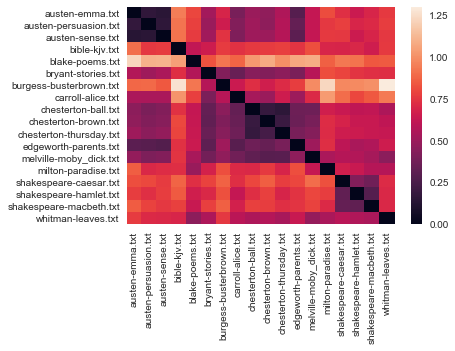

In [175]:
L = []
for p in corpora:
    l = []
    for q in corpora:
        l.append(Divergence(p,q, difference = 'KL'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

Note that works by the same author have the lowest within-group KL divergences. 

To reveal more patterns, let's do a multidimensional scaling of the matrix.

In [ ]:
mds = sklearn.manifold.MDS()
pos = mds.fit(M).embedding_
x = pos[:,0]
y = pos[:,1]
fig, ax = plt.subplots(figsize = (6,6))
plt.plot(x, y, ' ')
for i, txt in enumerate(fileids):
    ax.annotate(txt, (x[i],y[i]))

Do you see any patterns in the image shown above? Does it make sense?

We may just want to focus on the distrbution of stopwords or non-stopwords. Let's do the analysis again first for stopwords and then for non-stopwords.

In [ ]:
L = []
for p in corpora_s:
    l = []
    for q in corpora_s:
        l.append(Divergence(p,q, difference='KL'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

In [ ]:
L = []
for p in corpora_nons:
    l = []
    for q in corpora_nons:
        l.append(Divergence(p,q, difference='KL'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

Now we compute the same for the assymmetric $\chi^2$ Divergence.

In [ ]:
L = []
for p in corpora_nons:
    l = []
    for q in corpora_nons:
        l.append(Divergence(p,q, difference='Chi2'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

For the KS distance:

In [ ]:
L = []
for p in corpora_nons:
    l = []
    for q in corpora_nons:
        l.append(Divergence(p,q, difference='KS'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

And finally for the Wasserstein or "earth mover's" Distance.

In [ ]:
L = []
for p in corpora_nons:
    l = []
    for q in corpora_nons:
        l.append(Divergence(p,q, difference='Wasserstein'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

You can see that the Bible is highly divergent and this makes reading the plot somewhat difficult. Let's fix this by taking the log of each cell, which will reduce the distance of the Bible from other texts as an outlier.

In [ ]:
ax = sns.heatmap(div.apply(np.log).replace([np.inf, -np.inf], np.nan))
plt.show()

This is more legible, as it continues to show that the Bible is divergent, but other structure is also visible, such as the divergence of Austen's *Emma* and *Sense and Sensibility*, and Edgeworth's *The Parent's Assistant*. 

If we want to rerun this on a new data set of our own composition, we can be a bit more efficient with our coding. Let's use the Shakespeare texts from last week as example: 

In [ ]:
shakespeare_df = lucem_illud.loadTextDirectory('../data/Shakespeare')

Now we stem and remove stopwords

In [ ]:
shakespeare_df['tokenized_text'] = shakespeare_df['text'].apply(lambda x: nltk.word_tokenize(x))
shakespeare_df['normalized_tokens'] = shakespeare_df['tokenized_text'].apply(lambda x: normlizeTokens(x, stopwordLst = stop_words_nltk, stemmer = porter))

Create the corpus file and generate the heatmap:

In [ ]:
measure = 'KS' #"KL", "Chi2", "KS", "Wasserstein"
num_of_texts = 10 #The bigger this number the slower it will run, you can also try selecting your own plays
fileids_sp = list(shakespeare_df[:num_of_texts].index)
corpora_sp = list(shakespeare_df[:num_of_texts]['normalized_tokens'])
L = []
for p in corpora_sp:
    l = []
    for q in corpora_sp:
        l.append(Divergence(p,q, difference=measure))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids_sp, index = fileids_sp)
ax = sns.heatmap(div)
plt.show()

What are "The Passionate Pilgrim" and "The Phoenix and the Turtle"? Little known poems by Shakespeare that are unsurprisingly hard to classify, as they are so different from everything else he wrote.

## <span style="color:red">*Exercise 4*</span>

<span style="color:red">Construct cells immediately below this that calculate the KL and $\chi^2$ divergences, and the KS and Wasserstein distances between four separate corpora, plot these with heatmaps, and then array them in two dimensions with multidimensional scaling as above. What does this reveal about relations between the corpora? Which analysis (and divergence or distribution) distinguishes the authors or documents better? 

<span style="color:red">**Stretch**: Calculate the <a "href=https://en.wikipedia.org/wiki/Jensen–Shannon_divergence" target="_blank">Jensen-Shannon Divergence</a> between your four corpora. What is the relationship between the KL and JS divergences?</span> 

Comparing among Harry Potter series

In [46]:

hpBook['normalized_tokens'] = hpBook['tokenized_text'].apply(lambda x: normlizeTokens(x, stopwordLst = stop_words_nltk, stemmer = porter))
hpBook['tokenized_text'] = hpBook['text'].apply(lambda x: nltk.word_tokenize(x))


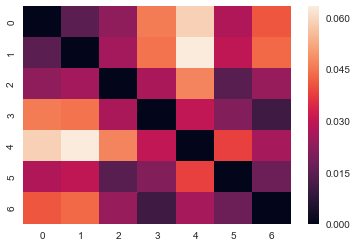

In [50]:
measure = 'KS' #"KL", "Chi2", "KS", "Wasserstein"
num_of_texts = 7 
fileids_sp = list(hpBook[:num_of_texts].index)
corpora_sp = list(hpBook[:num_of_texts]['normalized_tokens'])
L = []
for p in corpora_sp:
    l = []
    for q in corpora_sp:
        l.append(Divergence(p,q, difference=measure))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids_sp, index = fileids_sp)
ax = sns.heatmap(div)
plt.show()

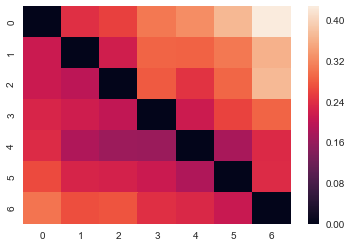

In [51]:
measure = 'KL' #"KL", "Chi2", "KS", "Wasserstein"
num_of_texts = 7 
fileids_sp = list(hpBook[:num_of_texts].index)
corpora_sp = list(hpBook[:num_of_texts]['normalized_tokens'])
L = []
for p in corpora_sp:
    l = []
    for q in corpora_sp:
        l.append(Divergence(p,q, difference=measure))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids_sp, index = fileids_sp)
ax = sns.heatmap(div)
plt.show()

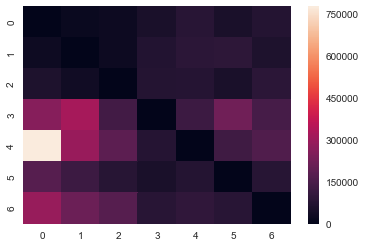

In [179]:
measure = 'Chi2' #"KL", "Chi2", "KS", "Wasserstein"
num_of_texts = 7 
fileids_sp = list(hpBook[:num_of_texts].index)
corpora_sp = list(hpBook[:num_of_texts]['normalized_tokens'])
L = []
for p in corpora_sp:
    l = []
    for q in corpora_sp:
        l.append(Divergence(p,q, difference=measure))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids_sp, index = fileids_sp)
ax = sns.heatmap(div)
plt.show()

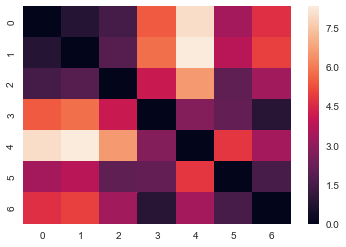

In [180]:
measure = 'Wasserstein' #"KL", "Chi2", "KS", "Wasserstein"
num_of_texts = 7 
fileids_sp = list(hpBook[:num_of_texts].index)
corpora_sp = list(hpBook[:num_of_texts]['normalized_tokens'])
L = []
for p in corpora_sp:
    l = []
    for q in corpora_sp:
        l.append(Divergence(p,q, difference=measure))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids_sp, index = fileids_sp)
ax = sns.heatmap(div)
plt.show()

Remarks: According to the heatmaps, KS and Wasserstein show similar patterns, and both distinguish the differences among seven books of Harry Potter pretty well. The first three books are close to each other, and also the last two books are quite related. among the other books, the fifth book, "Order of the Phoenix", is not very close to the first three books. 

What words do Harry Potter books overlap?

In [54]:
r = requests.get(bookLinks[0]['download_url'])
stoneBook = r.text
stoneWords = nltk.word_tokenize(stoneBook)
stoneNWords = normlizeTokens(stoneWords, stopwordLst = stop_words_nltk, stemmer = snowball)


In [55]:
r = requests.get(bookLinks[1]['download_url'])
secretsBook = r.text
secretsWords = nltk.word_tokenize(secretsBook)
secretsNWords = normlizeTokens(secretsWords, stopwordLst = stop_words_nltk, stemmer = snowball)

In [56]:
r = requests.get(bookLinks[2]['download_url'])
azkabanBook = r.text
azkabanWords = nltk.word_tokenize(azkabanBook)
azkabanNWords = normlizeTokens(azkabanWords, stopwordLst = stop_words_nltk, stemmer = snowball)

In [57]:
r = requests.get(bookLinks[3]['download_url'])
fireBook = r.text
fireWords = nltk.word_tokenize(fireBook)
fireNWords = normlizeTokens(fireWords, stopwordLst = stop_words_nltk, stemmer = snowball)

In [100]:
books_df = pandas.DataFrame({'Book' : [1,2,3,4], 'normalizedTokens' : [stoneNWords, secretsNWords, azkabanNWords, fireNWords]})
books_df

,Book,normalizedTokens
0,1,"[harri, potter, sorcer, stone, rowl, illustr, ..."
1,2,"[harri, potter, chamber, secret, rowl, illustr..."
2,3,"[harri, potter, prison, azkaban, rowl, illustr..."
3,4,"[harri, potter, goblet, fire, rowl, illustr, m..."


In [102]:
def getOverlap(tokens1, tokens2):
    overlapWords = set(tokens1) & set(tokens2) 
    overlapCounts = {}
    for word in [s for s in tokens1 if s in overlapWords]:
        try:
            overlapCounts[word] += 1
        except KeyError:
            overlapCounts[word] = 1
    return sorted(overlapCounts.items(), key = lambda x : x[1], reverse=True)

In [103]:
for t1 in books_df['normalizedTokens']:
          for t2 in books_df['normalizedTokens']:
            print(getOverlap(t1,t2)[:20])

[('harri', 1323), ('said', 794), ('ron', 425), ('look', 398), ('hagrid', 357), ('hermion', 265), ('one', 263), ('back', 261), ('go', 258), ('get', 231), ('like', 211), ('know', 211), ('got', 206), ('could', 198), ('see', 183), ('veri', 172), ('snape', 168), ('tri', 167), ('professor', 167), ('dumbledor', 151)]
[('harri', 1323), ('said', 794), ('ron', 425), ('look', 398), ('hagrid', 357), ('hermion', 265), ('one', 263), ('back', 261), ('go', 258), ('get', 231), ('like', 211), ('know', 211), ('got', 206), ('could', 198), ('see', 183), ('veri', 172), ('snape', 168), ('tri', 167), ('professor', 167), ('dumbledor', 151)]
[('harri', 1323), ('said', 794), ('ron', 425), ('look', 398), ('hagrid', 357), ('hermion', 265), ('one', 263), ('back', 261), ('go', 258), ('get', 231), ('like', 211), ('know', 211), ('got', 206), ('could', 198), ('see', 183), ('veri', 172), ('snape', 168), ('tri', 167), ('professor', 167), ('dumbledor', 151)]
[('harri', 1323), ('said', 794), ('ron', 425), ('look', 398), ('

In [105]:
getOverlap(books_df['normalizedTokens'][0], books_df['normalizedTokens'][1])

[('harri', 1323),
 ('said', 794),
 ('ron', 425),
 ('look', 398),
 ('hagrid', 357),
 ('hermion', 265),
 ('one', 263),
 ('back', 261),
 ('go', 258),
 ('get', 231),
 ('like', 211),
 ('know', 211),
 ('got', 206),
 ('could', 198),
 ('see', 183),
 ('veri', 172),
 ('snape', 168),
 ('tri', 167),
 ('professor', 167),
 ('dumbledor', 151),
 ('think', 146),
 ('around', 141),
 ('time', 134),
 ('dudley', 134),
 ('want', 134),
 ('say', 127),
 ('come', 127),
 ('never', 126),
 ('uncl', 122),
 ('right', 121),
 ('door', 121),
 ('even', 120),
 ('someth', 120),
 ('head', 120),
 ('yeh', 120),
 ('malfoy', 120),
 ('eye', 119),
 ('nevill', 116),
 ('turn', 115),
 ('hand', 113),
 ('vernon', 111),
 ('first', 110),
 ('face', 110),
 ('onli', 110),
 ('potter', 108),
 ('would', 108),
 ('well', 106),
 ('thing', 103),
 ('dursley', 102),
 ('way', 101),
 ('ask', 101),
 ('boy', 100),
 ('befor', 99),
 ('thought', 98),
 ('two', 98),
 ('peopl', 97),
 ('seem', 97),
 ('next', 95),
 ('told', 93),
 ('mcgonagal', 93),
 ('gryffind

In [104]:
getOverlap(books_df['normalizedTokens'][0], books_df['normalizedTokens'][3])

[('harri', 1323),
 ('said', 794),
 ('ron', 425),
 ('look', 398),
 ('hagrid', 357),
 ('hermion', 265),
 ('one', 263),
 ('back', 261),
 ('go', 258),
 ('get', 231),
 ('like', 211),
 ('know', 211),
 ('got', 206),
 ('could', 198),
 ('see', 183),
 ('veri', 172),
 ('snape', 168),
 ('tri', 167),
 ('professor', 167),
 ('dumbledor', 151),
 ('think', 146),
 ('around', 141),
 ('time', 134),
 ('dudley', 134),
 ('want', 134),
 ('say', 127),
 ('come', 127),
 ('never', 126),
 ('uncl', 122),
 ('right', 121),
 ('door', 121),
 ('even', 120),
 ('someth', 120),
 ('head', 120),
 ('yeh', 120),
 ('malfoy', 120),
 ('eye', 119),
 ('nevill', 116),
 ('turn', 115),
 ('hand', 113),
 ('vernon', 111),
 ('first', 110),
 ('face', 110),
 ('onli', 110),
 ('potter', 108),
 ('would', 108),
 ('well', 106),
 ('thing', 103),
 ('dursley', 102),
 ('way', 101),
 ('ask', 101),
 ('boy', 100),
 ('befor', 99),
 ('thought', 98),
 ('two', 98),
 ('peopl', 97),
 ('seem', 97),
 ('next', 95),
 ('told', 93),
 ('mcgonagal', 93),
 ('gryffind

In [78]:
overlapCounts = {}
for word in [s for s in stoneNWords if s in overlapWords]:
    try:
        overlapCounts[word] += 1
    except KeyError:
        overlapCounts[word] = 1

In [106]:
overlapWords = set(stoneNWords) & set(secretsNWords) 

overlapWordsDict = {word: index for index, word in enumerate(overlapWords)}

Compare Book 1 and Book 2

In [114]:
stone_df = pandas.DataFrame({'Book' : [1], 'normalized_tokens' : [stoneNWords]})


In [115]:
secrets_df = pandas.DataFrame({'Book' : [2], 'normalized_tokens' : [secretsNWords]})


In [116]:
stWords = set(stone_df['normalized_tokens'].sum())
seWords = set(secrets_df['normalized_tokens'].sum())

#Change & to | if you want to keep all words
overlapWords = stWords & seWords

overlapWordsDict = {word: index for index, word in enumerate(overlapWords)}


In [117]:
def makeProbsArray(dfColumn, overlapDict):
    words = dfColumn.sum()
    countList = [0] * len(overlapDict)
    for word in words:
        try:
            countList[overlapDict[word]] += 1
        except KeyError:
            #The word is not common so we skip it
            pass
    countArray = np.array(countList)
    return countArray / countArray.sum()

stProbArray = makeProbsArray(stone_df['normalized_tokens'], overlapWordsDict)
seProbArray = makeProbsArray(secrets_df['normalized_tokens'], overlapWordsDict)


In [118]:
stone_secretsDivergence = scipy.stats.entropy(stProbArray, seProbArray)
print (stone_secretsDivergence)
secrets_stoneDivergence = scipy.stats.entropy(seProbArray, stProbArray)
print (secrets_stoneDivergence)

0.16309297074738247
0.1701584823609404


Then, we can do the elementwise calculation and see which words best distinguish the Harry Potter 1 and 2.

In [119]:
stone_secretsDivergence_ew = scipy.special.kl_div(stProbArray, seProbArray)
kl_df = pandas.DataFrame(list(overlapWordsDict.keys()), columns = ['word'], index = list(overlapWordsDict.values()))
kl_df = kl_df.sort_index()
kl_df['elementwise divergence'] = stone_secretsDivergence_ew
kl_df[:10]

,word,elementwise divergence
0,shot,5.544881e-05
1,gloomi,2.900486e-07
2,pay,5.261895e-06
3,velvet,1.954227e-05
4,serv,3.618469e-05
5,either,2.144160e-05
6,afraid,1.891399e-04
7,collaps,2.154373e-04
8,stiff,5.518160e-05
9,drive,2.069485e-04


In [120]:
kl_df.sort_values(by='elementwise divergence', ascending=False)[:10]

,word,elementwise divergence
1682,yeh,0.003273
2293,hagrid,0.002870
2425,dudley,0.002370
1215,ginni,0.002300
1231,nevill,0.002075
2199,yer,0.001637
2262,dragon,0.001626
477,uncl,0.001566
1204,weasley,0.001406
2212,troll,0.001380
